In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pd.read_csv('/kaggle/input/i2a2-brasil-pneumonia-classification/train.csv')
df_train.head()

,fileName,pneumonia
0,ceba102d-27ba-4592-a0a6-60b217a94aa1.jpeg,0
1,7c05f8d3-57d4-4e4d-8dcd-7ae57699708c.jpeg,1
2,62914667-284b-4600-a14a-e22b19e8259b.jpeg,1
3,9a6d49e0-0996-420a-921b-8d9a8a37fca5.jpeg,1
4,ce0c8c09-3816-4ccc-95ae-68c3cf1344c7.jpeg,1


In [3]:
positive = df_train.query('pneumonia == 1')
print(len(positive))

negative = df_train.query('pneumonia == 0')
print(len(negative))

2991
1108


In [4]:
def show_images(df):
    for filename in df['fileName']:
      image = mpimg.imread(f"/kaggle/input/i2a2-brasil-pneumonia-classification/images/{filename}")
      imgplot = plt.imshow(image)
      plt.show()

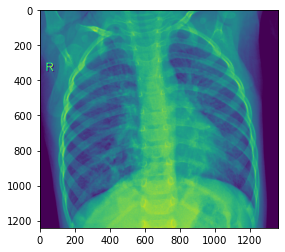

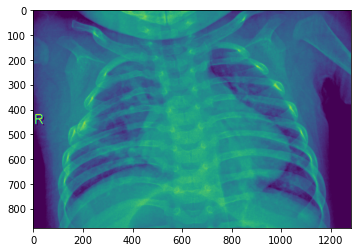

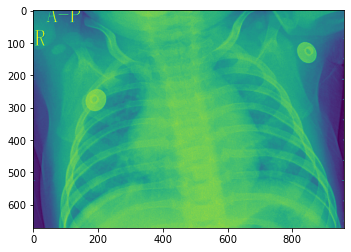

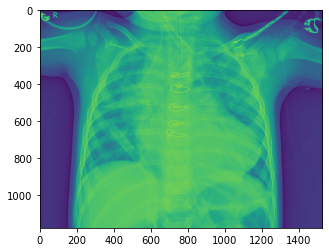

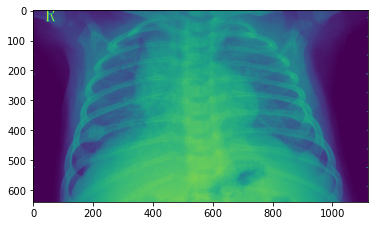

In [5]:
df = positive.head()
show_images(df)

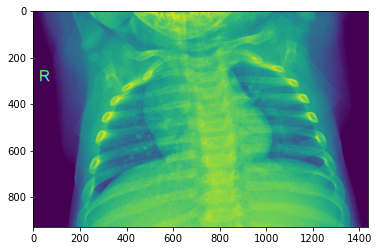

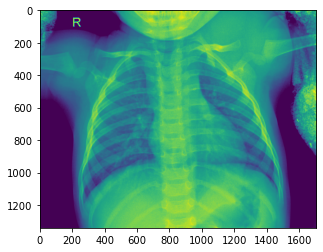

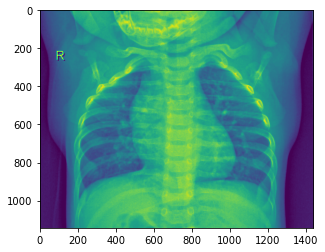

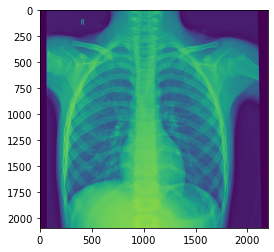

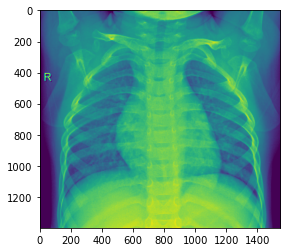

In [6]:
df = negative.head()
show_images(df)

In [7]:
df_test = pd.read_csv('/kaggle/input/i2a2-brasil-pneumonia-classification/test.csv')
df_test.head()

,fileName
0,ee9a09ba-0e24-4536-91d9-04d5f21d4056.jpeg
1,a46e7a54-5932-4638-8274-9df141243230.jpeg
2,f67d8ca6-63ea-4217-91d9-d8e9fc13094f.jpeg
3,da12b954-8356-45ba-a7b7-ae05659c0180.jpeg
4,a9e68a83-0c0f-42a5-b516-468b7a18cbe3.jpeg


## Neural network

In [8]:
import numpy as np
import os
import random
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

from keras.callbacks import EarlyStopping, ModelCheckpoint   
from keras.layers import Conv2D, Dense, Dropout, GlobalMaxPooling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

In [9]:
MODEL_PATH = 'model.pneumonia.weights.best.hdf5'

In [10]:
def init_model():
    if not os.path.isfile(MODEL_PATH):
        model = train()
        print('New train!')
    else:
        model = create_model()
        model.load_weights(MODEL_PATH)
        print('Using network trained!')

    return model

In [11]:
def prepare_dataset(df):
    images = [preprocess_images(f"/kaggle/input/i2a2-brasil-pneumonia-classification/images/{filename}") for filename in df['fileName']]
    images = np.array(images, dtype=np.float32)

    outputs = None
    if 'pneumonia' in df.columns:
        outputs = df['pneumonia']
    
    return images, outputs

def preprocess_images(filename):
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
    return preprocess_input(image) 

In [12]:
def create_model():
    base_model = InceptionResNetV2(weights="imagenet",
                          classes=2,
                          classifier_activation="softmax",
                          include_top=False, 
                          input_shape= (224, 224, 3))

    x = GlobalMaxPooling2D()(base_model.output)
    x = Dense(16, activation = 'relu')(x)
    x = Dense(1, activation = 'sigmoid')(x)

    model = Model(base_model.input, x)
    model.summary()
    
    return model

In [13]:
def train():
    df_train = pd.read_csv('/kaggle/input/i2a2-brasil-pneumonia-classification/train.csv')
    images, outputs = prepare_dataset(df_train)
    
    # divindo dataset de treinamento em treinamento, teste e validação
    x_train, x_test, y_train, y_test = train_test_split(images, outputs, test_size = 0.2, stratify = outputs)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, stratify = y_train)

    # normalização
    x_train = x_train.astype('float32')/255
    x_valid = x_valid.astype('float32')/255
    x_test = x_test.astype('float32')/255

    model = create_model()
    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])
    
    checkpointer = [ModelCheckpoint(filepath=MODEL_PATH, save_best_only=True),
                    EarlyStopping(patience= 15)]
    
    aug = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.15,
            horizontal_flip=True,
            fill_mode="nearest")
    
    class_weight = {
        0: 1.37044467,
        1: 3.69945848
    }
        
    hist = model.fit(
       x=aug.flow(x_train, y_train, batch_size=64),
       epochs=50,
       validation_data=(x_valid, y_valid),
       class_weight = class_weight,
       callbacks=checkpointer)

    # carregando os pesos que geraram a melhor precisão de validação
    model.load_weights(MODEL_PATH)

    # avaliar e imprimir a precisão do teste
    score = model.evaluate(x_test, y_test)
    print('\n', 'Test accuracy:', score[1])
    
    return model

In [14]:
train()

219062272/219055592 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
___________________________

__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 5, 5, 256)    172032      activation_193[0][0]             
__________________________________________________________________________________________________
batch_normalization_191 (BatchN (None, 5, 5, 192)    576         conv2d_191[0][0]                 
__________________________________________________________________________________________________
batch_normalization_194 (BatchN (None, 5, 5, 256)    768         conv2d_194[0][0]                 
__________________________________________________________________________________________________
activation_191 (Activation)     (None, 5, 5, 192)    0           batch_normalization_191[0][0]    
__________________________________________________________________________________________________
activation_194 (Activation)     (None, 5, 5, 256)    0           batch_normalization_194[0][0]    
__________

Epoch 1/50
41/41 [==============================] - 48s 1s/step - loss: 0.6800 - accuracy: 0.8323 - val_loss: 24294226.0000 - val_accuracy: 0.2698
Epoch 2/50
41/41 [==============================] - 42s 1s/step - loss: 0.3299 - accuracy: 0.9333 - val_loss: 715090.2500 - val_accuracy: 0.2698
Epoch 3/50
41/41 [==============================] - 42s 1s/step - loss: 0.2938 - accuracy: 0.9428 - val_loss: 39.5711 - val_accuracy: 0.2698
Epoch 4/50
41/41 [==============================] - 39s 940ms/step - loss: 0.2886 - accuracy: 0.9413 - val_loss: 5922.2075 - val_accuracy: 0.2698
Epoch 5/50
41/41 [==============================] - 39s 949ms/step - loss: 0.4096 - accuracy: 0.9371 - val_loss: 1618.5720 - val_accuracy: 0.2698
Epoch 6/50
41/41 [==============================] - 42s 1s/step - loss: 0.2667 - accuracy: 0.9489 - val_loss: 0.7202 - val_accuracy: 0.7302
Epoch 7/50
41/41 [==============================] - 41s 1s/step - loss: 0.2311 - accuracy: 0.9516 - val_loss: 0.6902 - val_accuracy: 0.

In [15]:
def predict_value(value):
    if value > 0.5:
        return 1
    return 0
    
def execute_prediction(df):
    X, _ = prepare_dataset(df)

    X = X.astype('float32')/255
    model = init_model()

    predictions = model.predict(X)
    predictions = [predict_value(pred) for pred in predictions]
    
    filenames = df['fileName']
    return pd.DataFrame({ "fileName": filenames, "pneumonia": predictions })

In [16]:
df_test = pd.read_csv('/kaggle/input/i2a2-brasil-pneumonia-classification/test.csv')
result_test = execute_prediction(df_test)
result_test.head(10)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

__________________________________________________________________________________________________
activation_370 (Activation)     (None, 5, 5, 192)    0           batch_normalization_370[0][0]    
__________________________________________________________________________________________________
activation_373 (Activation)     (None, 5, 5, 256)    0           batch_normalization_373[0][0]    
__________________________________________________________________________________________________
block8_2_mixed (Concatenate)    (None, 5, 5, 448)    0           activation_370[0][0]             
                                                                 activation_373[0][0]             
__________________________________________________________________________________________________
block8_2_conv (Conv2D)          (None, 5, 5, 2080)   933920      block8_2_mixed[0][0]             
__________________________________________________________________________________________________
block8_2 (

Using network trained!


,fileName,pneumonia
0,ee9a09ba-0e24-4536-91d9-04d5f21d4056.jpeg,0
1,a46e7a54-5932-4638-8274-9df141243230.jpeg,0
2,f67d8ca6-63ea-4217-91d9-d8e9fc13094f.jpeg,0
3,da12b954-8356-45ba-a7b7-ae05659c0180.jpeg,0
4,a9e68a83-0c0f-42a5-b516-468b7a18cbe3.jpeg,0
5,8d8ef262-1e4a-4341-8243-e52c95856e1d.jpeg,0
6,5a409835-2a56-4828-b330-954af46cf9c0.jpeg,1
7,961a006c-d78e-4fc1-b109-86ce89d718c5.jpeg,1
8,d6dc034b-9aae-4121-8905-0c4dfcdba77b.jpeg,1
9,a584fa1b-4681-4725-a35f-999e1da71f6e.jpeg,1


In [17]:
df_submission = pd.read_csv('/kaggle/input/i2a2-brasil-pneumonia-classification/sample_submission.csv')
result_submission = execute_prediction(df_submission)
result_submission.head(10)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_406 (BatchN (None, 111, 111, 32) 96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 111, 111, 32) 0           batch_normalization_406[0][0]    
____________________________________________________________________________________________

batch_normalization_587 (BatchN (None, 5, 5, 224)    672         conv2d_587[0][0]                 
__________________________________________________________________________________________________
activation_587 (Activation)     (None, 5, 5, 224)    0           batch_normalization_587[0][0]    
__________________________________________________________________________________________________
conv2d_585 (Conv2D)             (None, 5, 5, 192)    399360      block8_4_ac[0][0]                
__________________________________________________________________________________________________
conv2d_588 (Conv2D)             (None, 5, 5, 256)    172032      activation_587[0][0]             
__________________________________________________________________________________________________
batch_normalization_585 (BatchN (None, 5, 5, 192)    576         conv2d_585[0][0]                 
__________________________________________________________________________________________________
batch_norm

Using network trained!


,fileName,pneumonia
0,ee9a09ba-0e24-4536-91d9-04d5f21d4056.jpeg,0
1,a46e7a54-5932-4638-8274-9df141243230.jpeg,0
2,f67d8ca6-63ea-4217-91d9-d8e9fc13094f.jpeg,0
3,da12b954-8356-45ba-a7b7-ae05659c0180.jpeg,0
4,a9e68a83-0c0f-42a5-b516-468b7a18cbe3.jpeg,0
5,8d8ef262-1e4a-4341-8243-e52c95856e1d.jpeg,0
6,5a409835-2a56-4828-b330-954af46cf9c0.jpeg,1
7,961a006c-d78e-4fc1-b109-86ce89d718c5.jpeg,1
8,d6dc034b-9aae-4121-8905-0c4dfcdba77b.jpeg,1
9,a584fa1b-4681-4725-a35f-999e1da71f6e.jpeg,1


In [18]:
result_submission.to_csv("results.csv",index=False)